# Reproduce: You et al., Phys. Rev. B 71, 024532 (2005)

J. R. Johansson, http://jrjohansson.github.com, <robert@riken.jp>

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
from wavefunction.wavefunction2d import *

## Introduction

Here we reproduce some of the numerical results from You et al., PRB 71, 024532 (2005).

The numerics is programmed in Python and uses the [wavefunction](http://github.com/jrjohansson/wavefunction) Python package. For details of how the eigenvalue problem is written on matrix form using a Fourier series decomposition, see the documentation for the wavefunction package.

For more calculations of flux qubit wavefunctions, see the notebook that reproduces some of the results from Orlando et al., PRA 1999.

# The model

The Hamiltonian in the rotated coordinates, where $\phi_p = (\phi_1 + \phi_2)/2$ and $\phi_m = (\phi_1 - \phi_2)/2$, is [Eqs. (5,6) in You et al.]

$H_t = \frac{1}{2M_p}\left(-i\hbar\frac{\partial}{\partial\phi_p}\right)^2 + \frac{1}{2M_m}\left(-i\hbar\frac{\partial}{\partial\phi_m}\right)^2 + E_J(2 + \alpha - 2 \cos\phi_p\cos\phi_m - \alpha\cos(2\pi f + 2 \phi_m)) + \frac{1}{2}LI^2$

where

$M_p = \left(\frac{\Phi_0}{2\pi}\right)^2 2 C,$

$M_m = \left(\frac{\Phi_0}{2\pi}\right)^2 2 C(1 + 2\alpha).$

$I = I_c \sin(\varphi_p + \varphi_m)$

For the numerical calculations we use units of $E_J = I_c (\Phi_0/2\pi)$ 

$H_t = - 2\frac{E_C}{E_J}\left(\frac{\partial}{\partial\phi_p}\right)^2 
- \frac{2}{1 + 2\alpha}\frac{E_C}{E_J}\left(\frac{\partial}{\partial\phi_m}\right)^2 + (2 + \alpha - 2 \cos\phi_p\cos\phi_m - \alpha\cos(2\pi f + 2 \phi_m))+\frac{1}{2} \beta_L \sin^2(\varphi_p + \varphi_m)$

where $\beta_L = L/L_J$ and $L_J = \Phi_0/(2\pi I_c)$.

### Parameters

In [4]:
args = {'Ec': 1/35.0, 'Ej': 1.0, 'alpha': 0.8, 'f': 0.50, 'beta_L': 0.0}
globals().update(args)

### Assembling the matrix for the kinetic contribution

The kinetic part of the Hamiltonian can be written on the form

$\displaystyle K_{n_1, n_2}^{m_1, m_2} = \delta_{n_1,m_1} \delta_{n_2,m_2}
\left(k_{11}\left(\frac{2\pi m_1}{T_{x_1}}\right)^2 + k_{12}\frac{(2\pi)^2 m_1m_2}{T_{x_1}T_{x_2}} + k_{22}\left(\frac{2\pi m_2}{T_{x_2}}\right)^2\right)$

with

$k_{11} = 2\frac{E_C}{E_J}$

$k_{12} = 0$

$k_{22} = \frac{2}{1 + 2\alpha}\frac{E_C}{E_J}$

In [5]:
# pick a truncation of the fourier series: n1 = [-L1, ..., L1], n2 = [-L2, ..., L2]
L1 = 10
L2 = 10

# pick periods for the coordinates
Tx1 = Tx2 = 2 * np.pi

#
k11, k12, k22 = 2 * Ec / Ej, 0.0, 2 / (1 + 2 * alpha) * Ec / Ej

In [6]:
K = assemble_K(L1, L2, k11, k12, k22, Tx1, Tx2)

### Assembling the matrix for the potential contribution

The flux qubit potential we consider here is

$\displaystyle U(\varphi_p, \varphi_m) = 2 + \alpha - 2 \cos\phi_p\cos\varphi_m - \alpha\cos(2\pi f + 2 \varphi_m) +\frac{1}{2} \beta_L \sin^2(\varphi_p + \varphi_m)$

To obtain the Fourier series expansion of $U(x_p, x_m)$, we first write the $\cos$ and $\sin$ expressions as exponential functions

$\displaystyle U(\varphi_p, \varphi_m) = 2 + \alpha
- \frac{1}{2}(e^{i\varphi_p}e^{i\varphi_m} + e^{i\varphi_p}e^{-i\varphi_m} + e^{-i\varphi_p}e^{i\varphi_m} + e^{-i\varphi_p}e^{-i\varphi_m})
- \alpha\frac{1}{2}(e^{i2\pi f}e^{i2\varphi_m} + e^{-i2\pi f}e^{-i2\varphi_m})
- \frac{1}{8} \beta_L \left(e^{i2\varphi_p}e^{i2\varphi_m} + e^{-i2\varphi_p}e^{-i2\varphi_m} - 2\right)$

Now, by comparing with the Fourier series

$\displaystyle U(x_p, x_m) = \sum_{n_1}\sum_{n_2} u_{n_1n_2} e^{in_1x_p}e^{in_2x_m}$

we can identity

$\displaystyle u_{n_1n_2} = (2 + \alpha - \frac{1}{4}\beta_L) \delta_{0,n_1}\delta_{0,n_2} 
- 
\frac{1}{2}
(
\delta_{1, n_1}\delta_{1, n_2} + 
\delta_{1, n_1}\delta_{-1,n_2} + 
\delta_{-1, n_1}\delta_{1,n_2} + 
\delta_{-1, n_1}\delta_{-1,n_2}
)
- 
\frac{\alpha}{2} (e^{i2\pi f} \delta_{0,n_1}\delta_{+2,n_2} + e^{-i2\pi f}\delta_{0,n_1}\delta_{-2,n_2})
- 
\frac{\beta_L}{8} (\delta_{2,n_1}\delta_{2,n_2} + \delta_{-2,n_1}\delta_{-2,n_2})$

### Fourier series decomposition of flux qubit potential

In [7]:
def assemble_u_flux_qubit(L1, L2, args, sparse=False):

    globals().update(args)
    
    L1n = 2 * L1 + 1
    L2n = 2 * L2 + 1
    
    u = np.zeros((L1n, L2n), dtype=np.complex)

    u[L1, L2] = 2 + alpha - beta_L/4

    u[+1+L1, +1+L2] = - 0.5
    u[-1+L1, +1+L2] = - 0.5
    u[+1+L1, -1+L2] = - 0.5
    u[-1+L1, -1+L2] = - 0.5

    u[L1, +2+L2] = -0.5 * alpha * np.exp(+2j * np.pi * f)
    u[L1, -2+L2] = -0.5 * alpha * np.exp(-2j * np.pi * f)

    u[+2+L1, +2+L2] = -beta_L/8.0
    u[-1+L1, -2+L2] = -beta_L/8.0

    return u

In [8]:
u = assemble_u_flux_qubit(L1, L2, args)

### Plot the potential at different values of $\beta_L$: Fig. 2 in You et al.

Note: This could be done much simpler by just plotting $U(\varphi_p, \varphi_m)$, but here I calculate the potential by evaluating the corresponding Fourier series as a test of the Fourier decomposition (which is used later to calculate the potential contribution to the eigenvalue problem).

In [9]:
phi_p = np.linspace(-2*np.pi, 2*np.pi, 100)
phi_m = np.linspace(-2*np.pi, 2*np.pi, 100)
PHI_P, PHI_M = np.meshgrid(phi_p, phi_m)

In [10]:
U = evalute_fourier_series(PHI_P, PHI_M, L1, L2, u)

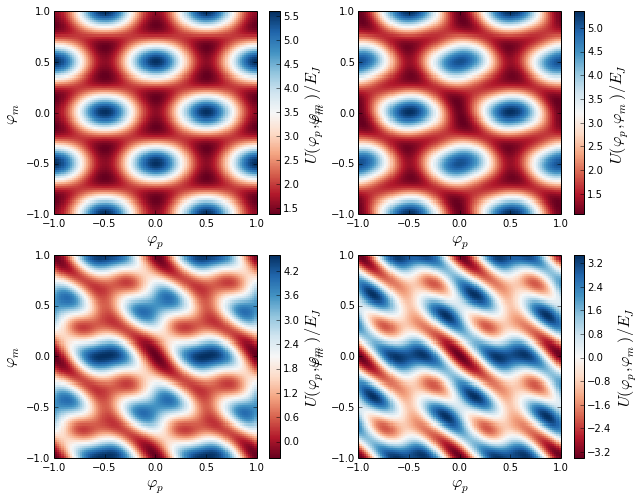

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for n, bL in enumerate([0.0, 1.0, 4.0, 10.0]):

    args['beta_L'] = bL
    
    u = assemble_u_flux_qubit(L1, L2, args)
    U = evalute_fourier_series(PHI_P, PHI_M, L1, L2, u)
    
    Z = np.real(U)
    p = axes[n // 2, n % 2].pcolor(PHI_P/(2*np.pi), PHI_M/(2*np.pi), Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max())
    cb = fig.colorbar(p, ax=axes[n // 2, n % 2])
    axes[n // 2, n % 2].axis('tight')
    axes[n // 2, n % 2].set_xlabel(r'$\varphi_p$', fontsize=16)
    axes[n // 2, n % 2].set_ylabel(r'$\varphi_m$', fontsize=16)
    cb.set_label(r'$U(\varphi_p, \varphi_m)/E_J$', fontsize=16);

### Potential contribution to the eigenvalue problem

In [12]:
phi_p = np.linspace(-np.pi, np.pi, 100)
phi_m = np.linspace(-np.pi, np.pi, 100)
PHI_P, PHI_M = np.meshgrid(phi_p, phi_m)

In [13]:
args['beta_L'] = 0    
u = assemble_u_flux_qubit(L1, L2, args)

Given this Fourier series we can calcuate the potential contribution to the eigenvalue problem as


$\displaystyle V_{n_1, n_2}^{m_1, m_2} = u_{n_1-m_1,n_2-m_2}$

and specifically for the flux qubit potential we can calculate this analytically:

$\displaystyle  V_{n_1, n_2}^{m_1, m_2} = (2 + \alpha - \beta_L/4) \delta_{0,n_1-m_1}\delta_{0,n_2-m_2} 
- 
\frac{1}{2}
(
\delta_{1, n_1-m_1}\delta_{1, n_2-m_2} + 
\delta_{1, n_1-m_1}\delta_{-1,n_2-m_2} + 
\delta_{-1, n_1-m_1}\delta_{1,n_2-m_2} + 
\delta_{-1, n_1-m_1}\delta_{-1,n_2-m_2}
)
- 
\frac{\alpha}{2} (e^{i2\pi f} \delta_{0,n_1-m_1}\delta_{+2,n_2-m_2} + e^{-i2\pi f}\delta_{0,n_1-m_1}\delta_{-2,n_2-m_2})
- 
\frac{\beta_L}{8} (\delta_{2,n_1-m_1}\delta_{2,n_2-m_2} + \delta_{-2,n_1-m_1}\delta_{-2,n_2-m_2})$

In [14]:
def assemble_V_flux_qubit(L1, L2, args, sparse=False):
    
    globals().update(args)
    
    L1n = 2 * L1 + 1
    L2n = 2 * L2 + 1
    
    V = np.zeros((L1n*L1n, L2n*L2n), dtype=np.complex)
    
    for n1 in np.arange(-L1, L1+1):
        for n2 in np.arange(-L1, L1+1):
            N = index_m2v(L1, n1, n2)
            for m1 in np.arange(-L2, L2+1):
                for m2 in np.arange(-L2, L2+1):
                    M = index_m2v(L2, m1, m2)

                    V[N,M] = (2 + alpha - 0.25 * beta_L) * delta(m1, n1) * delta(m2, n2) + \
                             - 0.5 * (delta(m1 + 1, n1) * delta(m2 + 1, n2) + 
                                      delta(m1 + 1, n1) * delta(m2 - 1, n2) + 
                                      delta(m1 - 1, n1) * delta(m2 + 1, n2) + 
                                      delta(m1 - 1, n1) * delta(m2 - 1, n2)) + \
                             - 0.5 * alpha * np.exp(+2j * np.pi * f) * delta(m1, n1) * delta(m2 + 2, n2) + \
                             - 0.5 * alpha * np.exp(-2j * np.pi * f) * delta(m1, n1) * delta(m2 - 2, n2) + \
                             - 0.125 * beta_L * delta(m1 + 2, n1) * delta(m2 + 2, n2) + \
                             - 0.125 * beta_L * delta(m1 - 2, n1) * delta(m2 - 2, n2)

    return V

In [15]:
V = assemble_V_flux_qubit(L1, L2, args)

## Solving the eigenvalue problem

We now want to solve the eigenvalue problem

$H \Psi = E \Psi$

where $H$ is the matrix representation of the Hamiltonian assembled from $K$ and $V$ above.

In [16]:
H = K + V

In [17]:
vals, vecs = solve_eigenproblem(H)

### Plot the wavefunctions for the lowest few eigenstates

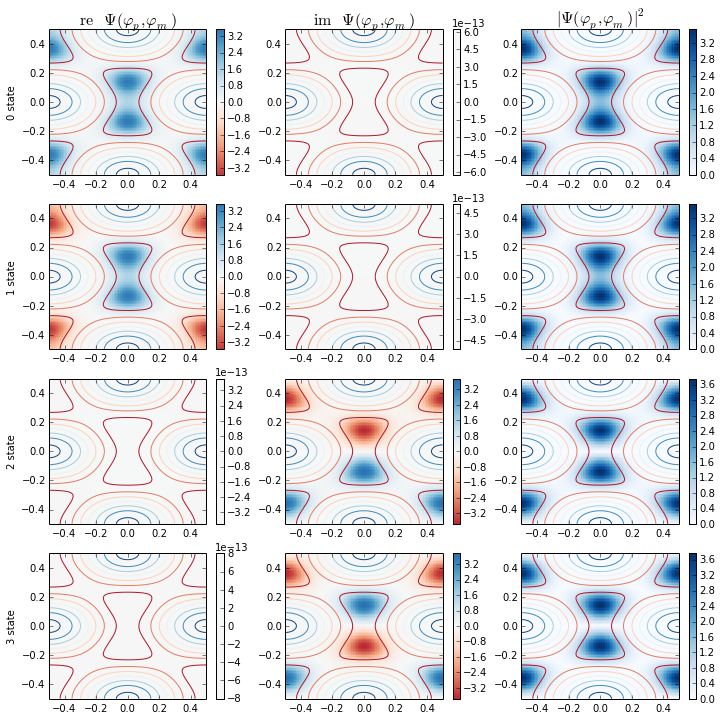

In [18]:
Nstates = 4

fig, axes = plt.subplots(Nstates, 3, figsize=(12, 3 * Nstates))

for n in range(Nstates):

    psi = convert_v2m(L1, L2, vecs[n])
    
    Z = np.real(evalute_fourier_series(PHI_P, PHI_M, L1, L2, u))
    PSI = evalute_fourier_series(PHI_P, PHI_M, L1, L2, psi)
    
    p = axes[n, 0].pcolor(PHI_P/(2*np.pi), PHI_M/(2*np.pi), np.real(PSI),
                          cmap=cm.RdBu, vmin=-abs(PSI.real).max(), vmax=abs(PSI.real).max())
    c = axes[n, 0].contour(PHI_P/(2*np.pi), PHI_M/(2*np.pi), Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max())
    cb = fig.colorbar(p, ax=axes[n, 0])
    cb.set_clim(-5, 5)

    p = axes[n, 1].pcolor(PHI_P/(2*np.pi), PHI_M/(2*np.pi), np.imag(PSI),
                          cmap=cm.RdBu, vmin=-abs(PSI.imag).max(), vmax=abs(PSI.imag).max())
    c = axes[n, 1].contour(PHI_P/(2*np.pi), PHI_M/(2*np.pi), Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max())
    cb = fig.colorbar(p, ax=axes[n, 1])
    cb.set_clim(-5, 5)
    
    p = axes[n, 2].pcolor(PHI_P/(2*np.pi), PHI_M/(2*np.pi), np.abs(PSI), cmap=cm.Blues, vmin=0, vmax=abs(PSI).max())
    c = axes[n, 2].contour(PHI_P/(2*np.pi), PHI_M/(2*np.pi), Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max())
    cb = fig.colorbar(p, ax=axes[n, 2])

    axes[n, 0].set_ylabel("%d state" % n);

axes[0, 0].set_title(r"$\mathrm{re}\;\Psi(\varphi_p, \varphi_m)$", fontsize=16);
axes[0, 1].set_title(r"$\mathrm{im}\;\Psi(\varphi_p, \varphi_m)$", fontsize=16);
axes[0, 2].set_title(r"$|\Psi(\varphi_p, \varphi_m)|^2$", fontsize=16);

### Energy levels as a function applied flux: Fig. 3 in You et al.

In [19]:
f_vec = np.linspace(0.45, 0.55, 50)

e_vals = np.zeros((4, len(vals), len(f_vec)))

In [20]:
for n, bL in enumerate([0.0, 0.1, 0.5, 1.0]):

    args['beta_L'] = bL

    K = assemble_K(L1, L2, k11, k12, k22, Tx1, Tx2)

    for f_idx, f in enumerate(f_vec):
        args['f'] = f
        V = assemble_V_flux_qubit(L1, L2, args)
        H = K + V
        vals, vecs = solve_eigenproblem(H)
    
        e_vals[n, :, f_idx] = np.real(vals)

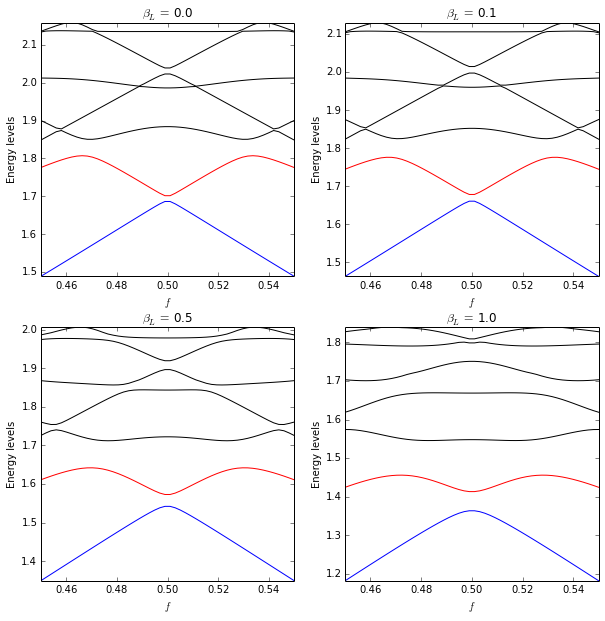

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

for n, bL in enumerate([0.0, 0.1, 0.5, 1.0]):

    idx = n // 2, n % 2
    
    axes[idx].plot(f_vec, e_vals[n, 0, :], 'b')
    axes[idx].plot(f_vec, e_vals[n, 2, :], 'r')
    for m in range(4, len(vals), 2):
        axes[idx].plot(f_vec, e_vals[n, m, :], 'k')
    
    axes[idx].axis('tight')
    axes[idx].set_ylim(e_vals[n, 0, :].min(), e_vals[n, 12, :].max())
    axes[idx].set_title(r"$\beta_L =$ %.1f" % bL)
    axes[idx].set_ylabel("Energy levels")
    axes[idx].set_xlabel(r'$f$');

Fig. 3 from You et al.

<img src="files/figures/you-pra-2005-fig-3.png" width="500"/>

TODO: discrepancy for large $\beta_L$, debug the self-inductance term in the potential.

## Software versions

In [22]:
%reload_ext version_information
%version_information numpy, scipy, matplotlib, wavefunction

Software versions
Python 3.3.1 (default, Apr 17 2013, 22:30:32) [GCC 4.7.3]
IPython 2.0.0-dev
OS posix [linux]
numpy 1.7.1
scipy 0.13.0.dev-ab773bf
matplotlib 1.4.x
wavefunction 1.0.0

Thu Aug 29 16:49:45 2013 JST